In [1]:
%config InlineBackend.figure_format = 'retina'
import loompy
import scipy.sparse as sparse
import logging
import numpy as np
import numba
from math import lgamma
import matplotlib.pyplot as plt
import cytograph as cg
from cytograph import HPF
from tqdm import trange
_ = np.seterr(invalid='ignore')  # Ignore np.sqrt() warnings for zeros in long vectors
logging.getLogger().setLevel(logging.DEBUG)

2018-10-28 19:45:17,013 INFO: ERROR: failed to import igraph; some clustering methods will not work
/Users/stelin/anaconda53/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
2018-10-28 19:45:20,811 DEBUG: backend module://ipykernel.pylab.backend_inline version unknown


/Users/stelin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log2
  if sys.path[0] == '':
/Users/stelin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log2
/Users/stelin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log2


1.0


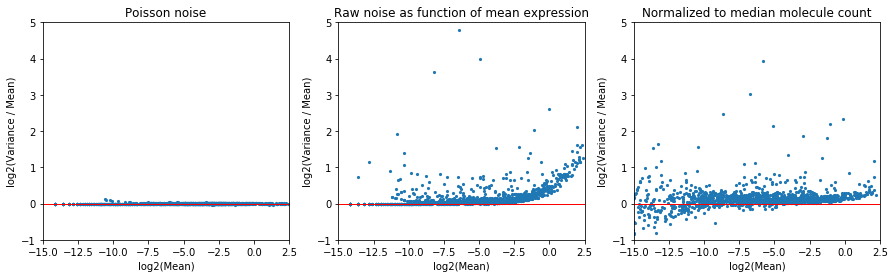

In [17]:
from scipy import stats
with loompy.connect("/Users/stelin/Dropbox (Linnarsson Group)/Temp/L1_OligoPons.loom", validate=False) as ds:
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(131)
    data = ds[550:6550, :]
    mu = np.mean(data, axis=1)
    var = np.zeros_like(mu)
    for i, m in enumerate(mu):
        sample = np.random.poisson(m, size=data.shape[1])
        var[i] = np.var(sample)
        mu[i] = np.mean(sample)
    plt.scatter(np.log2(mu), np.log2(var / mu), lw=0, s=40, marker='.')
    plt.ylim(-1,5)
    plt.xlim(-15,2.5)
    plt.title("Poisson noise")
    plt.ylabel("log2(Variance / Mean)")
    plt.xlabel("log2(Mean)")
    ax.axhline(y=0, color='red', lw=1)

    ax = fig.add_subplot(132)
    mu = np.mean(data, axis=1)
    var = np.var(data, axis=1)
    plt.scatter(np.log2(mu), np.log2(var / mu), lw=0, s=40, marker='.')
    plt.ylim(-1,5)
    plt.xlim(-15,2.5)
    plt.title("Raw noise as function of mean expression")
    plt.ylabel("log2(Variance / Mean)")
    plt.xlabel("log2(Mean)")
    ax.axhline(y=0, color='red', lw=1)

    ax = fig.add_subplot(133)
    data = data / data.sum(axis=0) * np.median(data.sum(axis=0))
    mu = np.mean(data, axis=1)
    var = np.var(data, axis=1)
    plt.scatter(np.log2(mu), np.log2(var / mu), lw=0, s=40, marker='.')
    plt.ylim(-1,5)
    plt.xlim(-15,2.5)
    plt.title("Normalized to median molecule count")
    plt.ylabel("log2(Variance / Mean)")
    plt.xlabel("log2(Mean)")
    ax.axhline(y=0, color='red', lw=1)

In [16]:
#f = "/Users/stelin/build_20171205/L1_Sympathetic_nfactors=100_k=20_ksmoothing=10_a=1_b=10_c=1_d=10_log=True_normalize=True_accel=False.loom"
#f = "/Users/stelin/build_20171205/L1_Hippocampus.loom"
f = "/Users/stelin/build_20171205/L3_Ependymal.loom"
with loompy.connect(f) as ds:
    normalizer = cg.Normalizer(False)
    normalizer.fit(ds)
    selected = cg.FeatureSelection(1000).fit(ds, mu=normalizer.mu, sd=normalizer.sd)
    data = ds.sparse(rows=selected).T
    # n_clusters = ds.ca.Clusters.max() + 1
    # data = sparse.coo_matrix(ds[:10 * n_clusters, :]).T
    hpf = HPF(k=48, validation_fraction=0.05, min_iter=10, max_iter=100, max_r=0.9).fit(data)

2018-09-17 23:22:02,155 INFO: nnz=417210
/Users/stelin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
HPF.fit(X.shape=(2543, 1000)):  20%|█▉        | 20/101 [00:13<00:54,  1.50it/s, diff=-0.0612, ll=-6.46e+04]


In [3]:
x=np.log2(hpf.X_ppv[(hpf.validation_data.row,hpf.validation_data.col)].reshape(-1))
y=data.toarray()[(hpf.validation_data.row,hpf.validation_data.col)].reshape(-1)
y=np.log2(y+np.random.uniform(0,0.5,size=y.shape[0]))

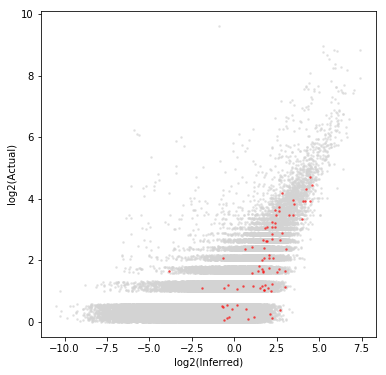

In [5]:
with loompy.connect(f) as ds:
    #outliers = (y > 6 + x*0.5)
    #outliers = (y > 2.5) & (x < 0.7)
    outliers = hpf.validation_data.col == np.where(selected == np.where(ds.ra.Gene == "Ccdc153")[0][0])[0][0]
    #outliers = outliers & (x < 2)
    plt.figure(figsize=(6,6))
    plt.scatter(x=x[~outliers],y=y[~outliers],marker='.',c="lightgrey",alpha=0.5, s=10)
    plt.scatter(x=x[outliers],y=y[outliers],marker='.',c="red",alpha=0.5, s=10)
    plt.ylabel("log2(Actual)")
    plt.xlabel("log2(Inferred)")

In [6]:
cells = hpf.validation_data.row[outliers]
with loompy.connect(f) as ds:
    fig = plt.figure(figsize=(5, 5))
    #plt.scatter(x=ds.ca.TSNE[:, 0], y=ds.ca.TSNE[:, 1], c='lightgrey',marker='.', alpha=0.9,s=50,lw=0)
    #plt.scatter(x=ds.ca.TSNE[:, 0][cells], y=ds.ca.TSNE[:, 1][cells], c='red',cmap="viridis",marker='.', alpha=0.9,s=50,lw=0)
    plt.scatter(x=ds.ca.TSNE[:, 0], y=ds.ca.TSNE[:, 1], c=np.log(ds[ds.ra.Gene == "Ccdc153",:][0]+1),cmap=zviridis,marker='.', alpha=0.5,s=50,lw=0)

AttributeError: '<class 'loompy.attribute_manager.AttributeManager'>' object has no attribute 'TSNE'

<Figure size 360x360 with 0 Axes>

In [61]:
with loompy.connect(f) as ds:
    genes = ds.ra.Gene[selected[hpf.validation_data.col[outliers]]]
print(sorted(genes))

['Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7', 'Fabp7']


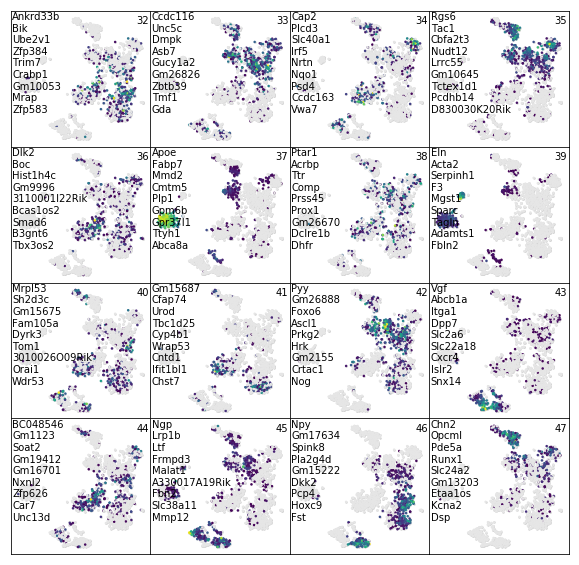

In [130]:
with loompy.connect(f) as ds:
    n_factors = hpf.k
    offset = 32
    beta = np.zeros((ds.shape[0], n_factors))
    beta[selected, :] = (hpf.beta.T / hpf.beta.sum(axis=1)).T
    theta = (hpf.theta.T / hpf.theta.sum(axis=1)).T
    fig = plt.figure(figsize=(10, 10))
    fig.subplots_adjust(hspace=0, wspace=0)
    for nnc in range(offset, offset + 16):
        if nnc >= n_factors:
            break
        ax = plt.subplot(4, 4, nnc + 1 - offset)
        plt.xticks(())
        plt.yticks(())
        cells = theta[:, nnc] > 0
        plt.scatter(x=ds.ca.TSNE[:, 0], y=ds.ca.TSNE[:, 1], c='lightgrey', marker='.', vmin=0.025, alpha=1,s=25,lw=0)
        plt.scatter(x=ds.ca.TSNE[:, 0][cells], y=ds.ca.TSNE[:, 1][cells], c=theta[:, nnc][cells], marker='.', vmin=0.025, alpha=1,s=25,lw=0, cmap=zviridis)
        ax.text(.01, .99, '\n'.join(ds.ra.Gene[np.argsort(-beta[:, nnc])][:9]), horizontalalignment='left', verticalalignment="top", transform=ax.transAxes)
        ax.text(.99, .9, f"{nnc}", horizontalalignment='right', transform=ax.transAxes)


In [ ]:
B230307C23Rik

In [7]:
from sklearn.neighbors import NearestNeighbors
logging.info("Generating radius-limited KNN graph")
k = 20
theta = (hpf.theta.T / hpf.theta.sum(axis=1)).T
logging.info("Fitting a ball tree index")
nn = cg.BalancedKNN(k, metric=cg.jensen_shannon_distance, n_jobs=1)
nn.fit(theta)
logging.info("Finding nearest neighbors")
knn = nn.kneighbors_graph(theta, mode='distance')
mknn = knn.minimum(knn.transpose())

2018-09-14 17:08:33,347 INFO: Generating radius-limited KNN graph
2018-09-14 17:08:33,349 INFO: Fitting a ball tree index
2018-09-14 17:08:33,350 DEBUG: First search the 100 nearest neighbours for 2543
2018-09-14 17:08:33,454 INFO: Finding nearest neighbors
2018-09-14 17:09:05,442 DEBUG: Using the initialization network to find a 20-NN graph with maximum connectivity of 200
2018-09-14 17:09:05,445 DEBUG: Returning sparse matrix


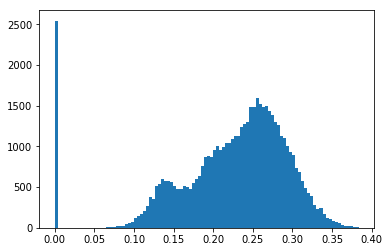

In [8]:
_=plt.hist(knn.data, bins=100)

In [9]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, metric=cg.jensen_shannon_distance, early_exaggeration=20, perplexity=30)
xy = tsne.fit_transform(theta)

In [11]:
knn.data = 1 - knn.data
mknn.data = 1 - mknn.data
with loompy.connect(f) as ds:
    ds.ca.TSNE = xy
    ds.col_graphs.KNN = knn
    ds.col_graphs.MKNN = mknn
    labels = cg.PolishedLouvain(outliers=False).fit_predict(ds)

2018-09-14 17:10:43,983 INFO: Louvain community detection
2018-09-14 17:10:45,780 INFO: Marking tiny clusters as outliers
2018-09-14 17:10:45,791 INFO: Using DBSCAN to mark outliers
2018-09-14 17:10:45,930 INFO: Using neighborhood to mark outliers
2018-09-14 17:10:46,094 INFO: Breaking clusters
2018-09-14 17:10:47,482 INFO: Smoothing cluster identity on the embedding


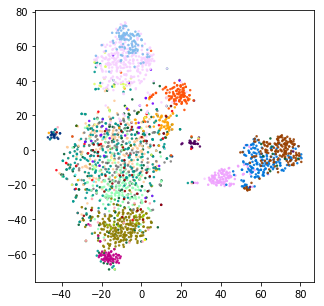

In [19]:
with loompy.connect(f) as ds:
    labels = ds.ca.Clusters
    fig = plt.figure(figsize=(5, 5))
    g = np.where(ds.ra.Gene[selected] == "Fabp7")[0]
    plt.scatter(x=xy[:, 0], y=xy[:, 1], c=cg.colorize(labels, bgval=-1), marker='.', alpha=0.9,s=25,lw=0)
    #plt.scatter(x=xy[:, 0], y=xy[:, 1], c=data.toarray()[:, g].T[0], cmap=zviridis, marker='.', alpha=0.9,s=50,lw=0)

In [1]:
import cytograph as cg
from sklearn.neighbors import BallTree as skBallTree
import numpy as np


2018-09-17 23:01:34,110 INFO: ERROR: failed to import igraph; some clustering methods will not work
2018-09-17 23:01:41,491 DEBUG: backend module://ipykernel.pylab.backend_inline version unknown


In [17]:
theta = (hpf.theta.T / hpf.theta.sum(axis=1)).T
#theta = np.random.uniform(size=(400,10))
xy = cg.tsne_js(theta)

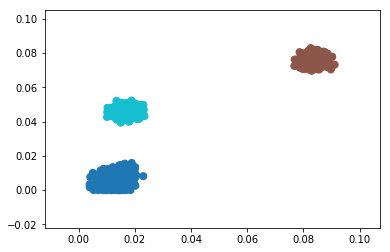

In [12]:
from sklearn.datasets import make_blobs
X, y = make_blobs(1000, 20, centers=3, cluster_std=0.5)
X = (X.T - np.min(X, axis=1)).T
X = (X.T / X.sum(axis=1)).T
plt.scatter(X[:, 0], X[:, 2], c=y, s=20, cmap="tab10")

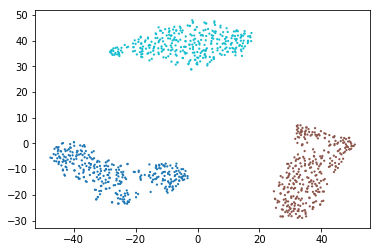

In [14]:
from sklearn.manifold import TSNE
nn = cg.BallTreeJS(data=X)
d,i = nn.query(None, k=100)
xy = cg.tsne_js(X)
plt.scatter(xy[:,0], xy[:,1],c=y,marker='.',lw=0,s=20, cmap="tab10")

In [19]:
%%time
nn = cg.BallTreeJS(data=X)
distances1, indices1 = nn.query(X, k=5)

CPU times: user 1.99 s, sys: 6.47 ms, total: 1.99 s
Wall time: 515 ms


In [26]:
distances1[:,1:]

array([[0.        , 0.00854194, 0.01116549, 0.01141867, 0.01189737],
       [0.        , 0.01124075, 0.01238646, 0.0126238 , 0.01362803],
       [0.        , 0.01413271, 0.01446922, 0.0154578 , 0.01590119],
       ...,
       [0.        , 0.00875285, 0.0090522 , 0.00932637, 0.00940357],
       [0.        , 0.01189018, 0.01268119, 0.0127629 , 0.01298555],
       [0.        , 0.00916064, 0.01022011, 0.01062073, 0.01107023]])

In [11]:
%%time
nn = skBallTree(data=theta, metric="pyfunc", func=cg.jensen_shannon_distance, leaf_size=40)
distances2, indices2 = nn.query(theta, k=5)

CPU times: user 31.4 s, sys: 123 ms, total: 31.5 s
Wall time: 31.5 s


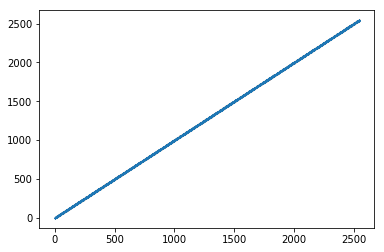

In [14]:
plt.scatter(indices1, indices2, marker=".", lw=0, s=10)

In [20]:
from umap import UMAP

In [39]:

@numba.jit("float32(float32[:], float32[:])", nopython=True, cache=True)
def jensen_shannon_divergence(pk: np.ndarray, qk: np.ndarray) -> float:
	N = pk.shape[0]
#	pk = pk / np.sum(pk)
#	qk = qk / np.sum(qk)
	m = (pk + qk) / 2

	vec = np.zeros(N)
	for i in range(N):
		if pk[i] > 0 and m[i] > 0:
			vec[i] = pk[i] * np.log(pk[i] / m[i])
		elif pk[i] == 0 and m[i] >= 0:
			vec[i] = 0
		else:
			vec[i] = np.inf
	Dpm = np.sum(vec) / np.log(2)

	vec = np.zeros(N)
	for i in range(N):
		if qk[i] > 0 and m[i] > 0:
			vec[i] = qk[i] * np.log(qk[i] / m[i])
		elif qk[i] == 0 and m[i] >= 0:
			vec[i] = 0
		else:
			vec[i] = np.inf
	Dqm = np.sum(vec) / np.log(2)

	return (Dpm + Dqm) / 2


@numba.jit("float32(float32[:], float32[:])", nopython=True, cache=True)
def jensen_shannon_distance(pk: np.ndarray, qk: np.ndarray) -> float:
	"""
	Remarks:
		pk and qk must already be normalized so that np.sum(pk) == np.sum(qk) == 1
	"""
	N = pk.shape[0]
#	pk = pk / np.sum(pk)
#	qk = qk / np.sum(qk)
	m = (pk + qk) / 2

	Dpm = jensen_shannon_divergence(pk, m)
	Dqm = jensen_shannon_divergence(qk, m)

	return np.sqrt((Dpm + Dqm) / 2)



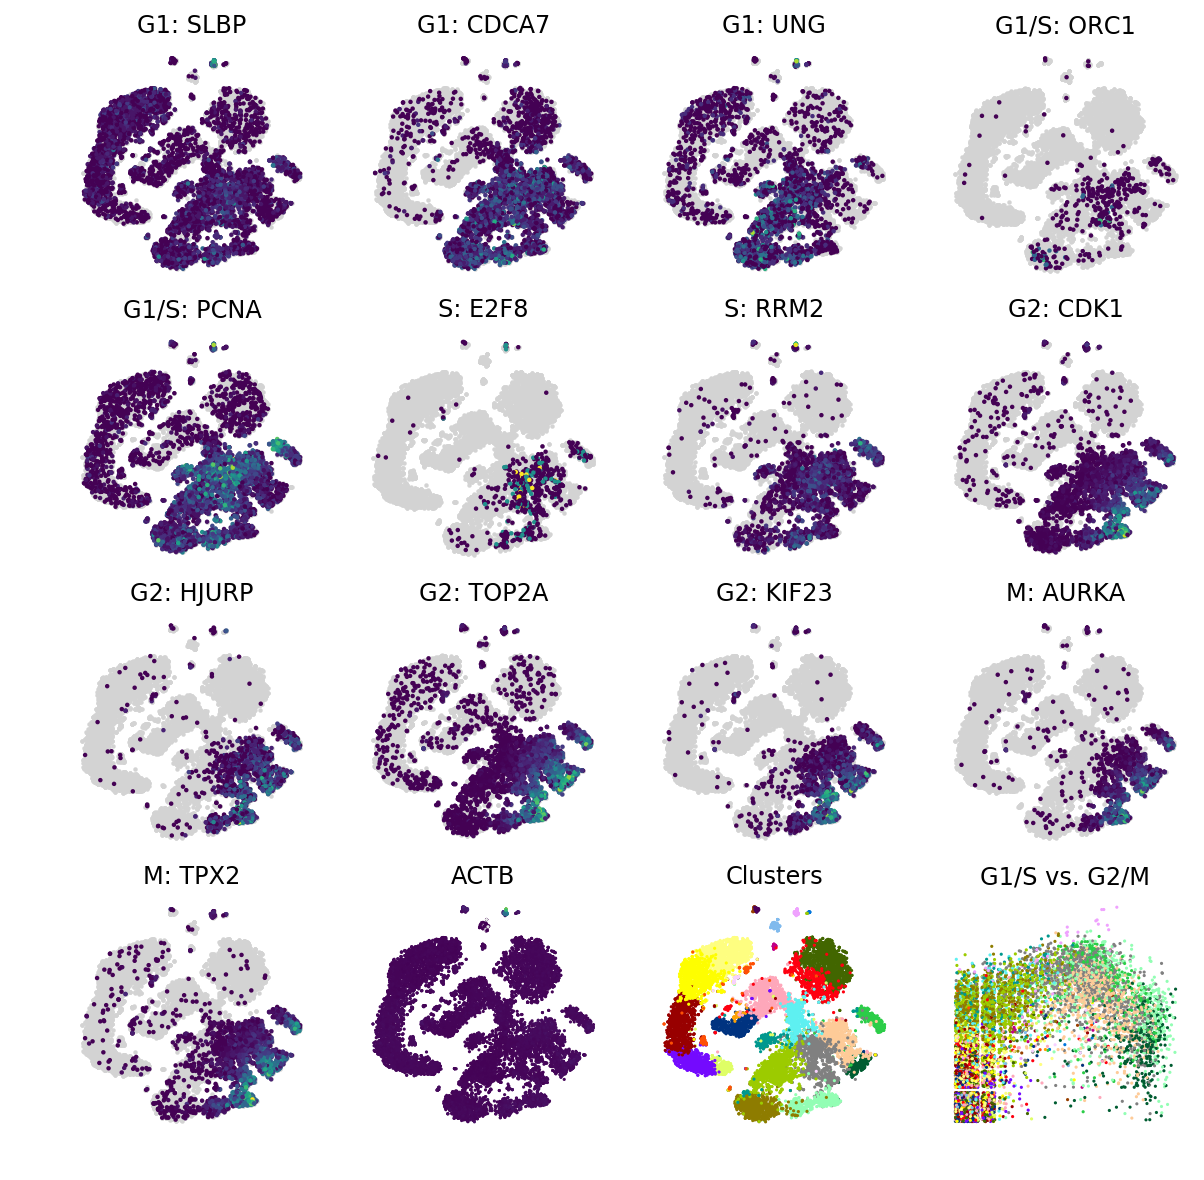

In [20]:
with loompy.connect("/Users/stelin/dh_20170213/L1_Subcortex.loom") as ds:
    xy = ds.ca.TSNE
    labels = ds.ca.Clusters
    layer = ds["pooled"]
    cellcycle = {
        "G1": ["SLBP", "CDCA7", "UNG"],
        "G1/S": ["ORC1", "PCNA"],
        "S": ["E2F8", "RRM2"],
        "G2": ["CDK1", "HJURP", "TOP2A", "KIF23"],
        "M": ["AURKA", "TPX2"]
    }
    plt.figure(figsize=(10,10))
    ix = 1
    for phase in cellcycle.keys():
        for g in cellcycle[phase]:
            expr = layer[ds.ra.Gene == g, :][0]
            ax = plt.subplot(4,4,ix)
            ax.axis("off")
            plt.title(phase + ": " + g)
            plt.scatter(xy[:,0], xy[:,1],c="lightgrey",marker='.',lw=0,s=20)
            cells = expr > 0
            plt.scatter(xy[:,0][cells], xy[:,1][cells],c=expr[cells],marker='.',lw=0,s=20, cmap="viridis")
            ix += 1
    ax = plt.subplot(4,4,ix)
    ax.axis("off")
    plt.title("ACTB")
    plt.scatter(xy[:,0], xy[:,1],c=layer[ds.ra.Gene == "ACTB", :][0],marker='.',lw=0,s=10, cmap=zviridis)
    ix += 1
    ax = plt.subplot(4,4,ix)
    ax.axis("off")
    plt.title("Clusters")
    plt.scatter(xy[:,0], xy[:,1],c=cg.colorize(ds.ca.Clusters),marker='.',lw=0,s=10)
    ix += 1
    ax = plt.subplot(4,4,ix)
    ax.axis("off")
    plt.title("G1/S vs. G2/M")
    g1 = layer[ds.ra.Gene == "SLBP", :][0] + layer[ds.ra.Gene == "CDCA7", :][0] + layer[ds.ra.Gene == "UNG", :][0] + layer[ds.ra.Gene == "ORC1", :][0] + layer[ds.ra.Gene == "PCNA", :][0] + layer[ds.ra.Gene == "E2F8", :][0] + layer[ds.ra.Gene == "RRM2", :][0]
    g2 = layer[ds.ra.Gene == "CDK1", :][0] + layer[ds.ra.Gene == "HJURP", :][0] + layer[ds.ra.Gene == "TOP2A", :][0] + layer[ds.ra.Gene == "KIF23", :][0] + layer[ds.ra.Gene == "AURKA", :][0] + layer[ds.ra.Gene == "TPX2", :][0]
    g1 = np.log2(g1 + np.random.uniform(1,1.8,size=g1.shape))
    g2 = np.log2(g2 + np.random.uniform(1,1.8,size=g2.shape))
    ordering = np.random.permutation(g1.shape[0])
    plt.scatter(x=g2[ordering], y=g1[ordering],c=cg.colorize(ds.ca.Clusters)[ordering],marker='.',lw=0,s=10)
    

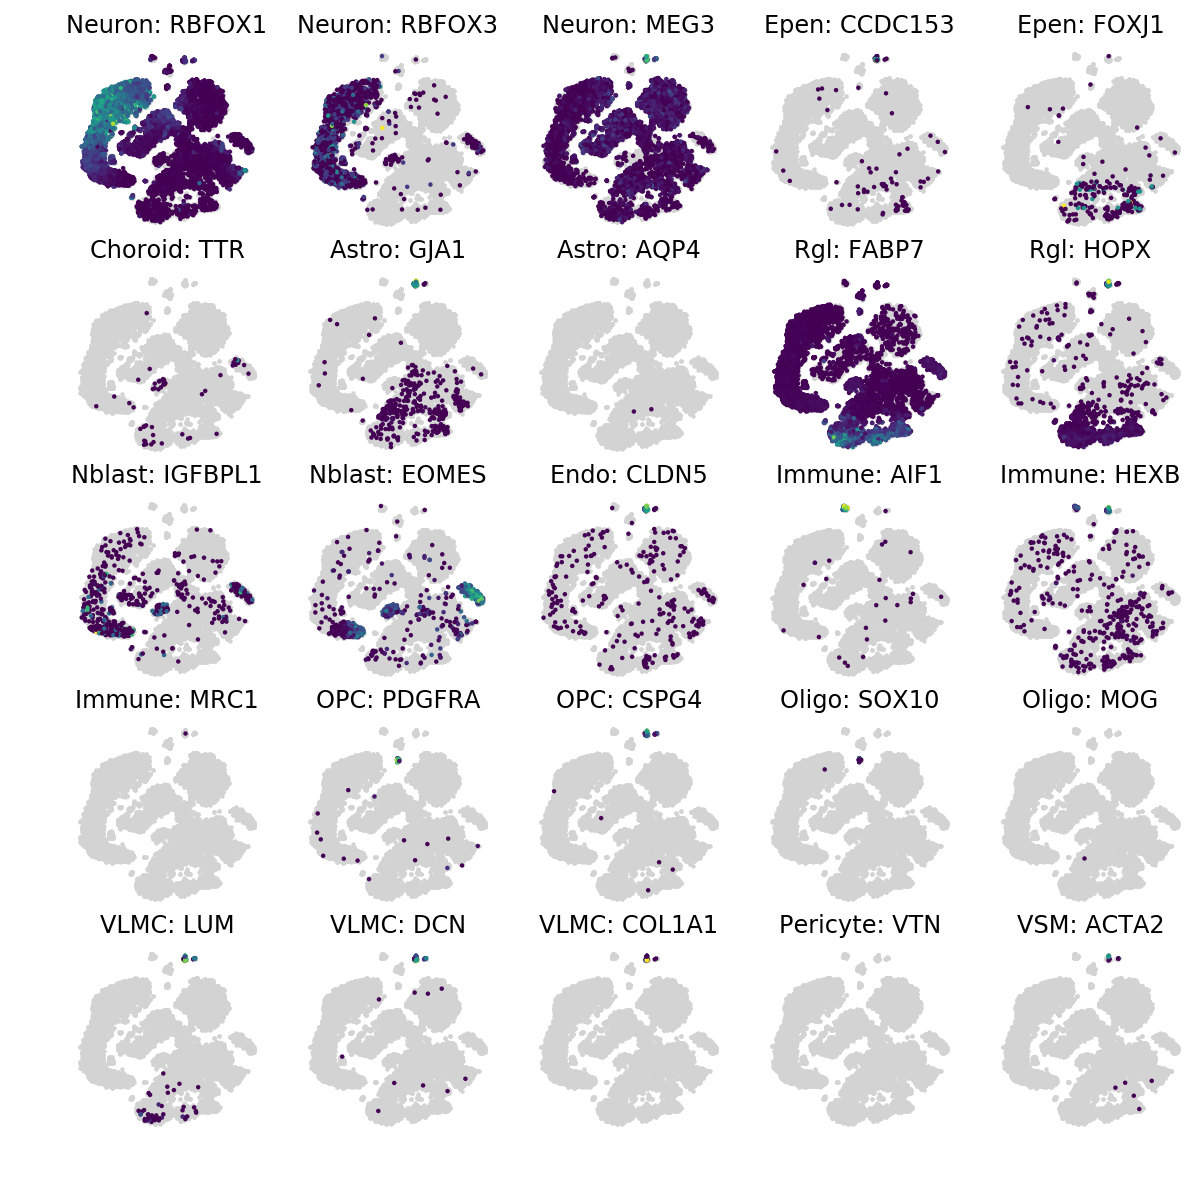

In [23]:
with loompy.connect("/Users/stelin/dh_20170213/L1_Subcortex.loom") as ds:
    xy = ds.ca.TSNE
    labels = ds.ca.Clusters
    layer = ds["pooled"]
    markers = {
        "Neuron": ["RBFOX1", "RBFOX3", "MEG3"],
        "Epen": ["CCDC153", "FOXJ1"],
        "Choroid": ["TTR"],
        "Astro": ["GJA1", "AQP4"],
        "Rgl": ["FABP7", "HOPX"],
        "Nblast": ["IGFBPL1", "EOMES"],
        "Endo": ["CLDN5"],
        "Immune": ["AIF1", "HEXB", "MRC1"],
        "OPC": ["PDGFRA", "CSPG4"],
        "Oligo": ["SOX10", "MOG"],
        "VLMC": ["LUM", "DCN", "COL1A1"],
        "Pericyte": ["VTN"],
        "VSM": ["ACTA2"]
    }
    plt.figure(figsize=(10,10))
    ix = 1
    for celltype in markers.keys():
        for g in markers[celltype]:
            expr = layer[ds.ra.Gene == g, :][0]
            ax = plt.subplot(5,5,ix)
            ax.axis("off")
            plt.title(celltype + ": " + g)
            plt.scatter(xy[:,0], xy[:,1],c="lightgrey",marker='.',lw=0,s=20)
            cells = expr > 0
            plt.scatter(xy[:,0][cells], xy[:,1][cells],c=expr[cells],marker='.',lw=0,s=20, cmap="viridis")
            ix += 1

In [150]:
from typing import *
import scipy
def _fit1_slope_weighted(y: np.ndarray, x: np.ndarray, w: np.ndarray, limit_gamma: bool=False, bounds: Tuple[float, float]=(0, 20)) -> float:
    """Simple function that fit a weighted linear regression model without intercept
    """
    if not np.any(x):
        m = np.NAN
    elif not np.any(y):
        m = 0
    else:
        if limit_gamma:
            if np.median(y) > np.median(x):
                high_x = x > np.percentile(x, 90)
                up_gamma = np.percentile(y[high_x], 10) / np.median(x[high_x])
                up_gamma = np.maximum(1.5, up_gamma)
            else:
                up_gamma = 1.5  # Just a bit more than 1
            m = scipy.optimize.minimize_scalar(lambda m: np.sum(w * (x * m - y)**2), bounds=(1e-8, up_gamma), method="bounded").x
        else:
            m = scipy.optimize.minimize_scalar(lambda m: np.sum(w * (x * m - y)**2), bounds=bounds, method="bounded").x
    return m

def fit_slope_weighted(S: np.ndarray, U: np.ndarray, limit_gamma: bool=False, bounds: Tuple[float, float]=(0, 20), maxmin_perc: List[float]=[2, 98]) -> np.ndarray:
    """Loop through the genes and fits the slope
    S: np.ndarray, shape=(genes, cells)
        the independent variable (spliced)
    U: np.ndarray, shape=(genes, cells)
        the dependent variable (unspliced)

    
    Remarks:
        Original code for velocyto.org bby Gioele La Manno. This  simplified version 
        by Sten Linnarsson.
    """

    denom_S = np.percentile(S, 99.9, 1)
    if np.sum(denom_S == 0):
        denom_S[denom_S == 0] = np.maximum(np.max(S[denom_S == 0, :], 1), 0.001)
    denom_U = np.percentile(U, 99.9, 1)
    if np.sum(denom_U == 0):
        denom_U[denom_U == 0] = np.maximum(np.max(U[denom_U == 0, :], 1), 0.001)
    S_maxnorm = S / denom_S[:, None]
    U_maxnorm = U / denom_U[:, None]
    X = S_maxnorm + U_maxnorm
    down, up = np.percentile(X, maxmin_perc, axis=1)
    W = ((X <= down[:, None]) | (X >= up[:, None])).astype(float)

    slopes = np.zeros(S.shape[0], dtype="float32")
    for i in range(S.shape[0]):
        m = _fit1_slope_weighted(U[i, :], S[i, :], W[i, :], limit_gamma)
        slopes[i] = m
    return slopes

with loompy.connect("/Users/stelin/dh_20170213/L1_Subcortex.loom") as ds:
    s = ds["spliced"][ds.ra.Selected == 1, :]
    u = ds["unspliced"][ds.ra.Selected == 1, :]
    gammas = fit_slope_weighted(s,u)

In [151]:
gammas

array([1.1492007e-01, 3.7316623e-01, 3.2363995e-04, ..., 0.0000000e+00,
       1.3565571e-02, 2.0916127e-04], dtype=float32)

In [33]:
with loompy.connect("/Users/stelin/dh_20170213/L1_Subcortex.loom") as ds:
    xy = UMAP(metric="cosine", spread=2, repulsion_strength=2, n_neighbors=50, n_components=2).fit_transform(ds.ca.HPF)
    labels = ds.ca.Clusters
    ds.ca.TSNE = xy

/Users/stelin/anaconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding 3 connected components using meta-embedding (experimental)
  n_components


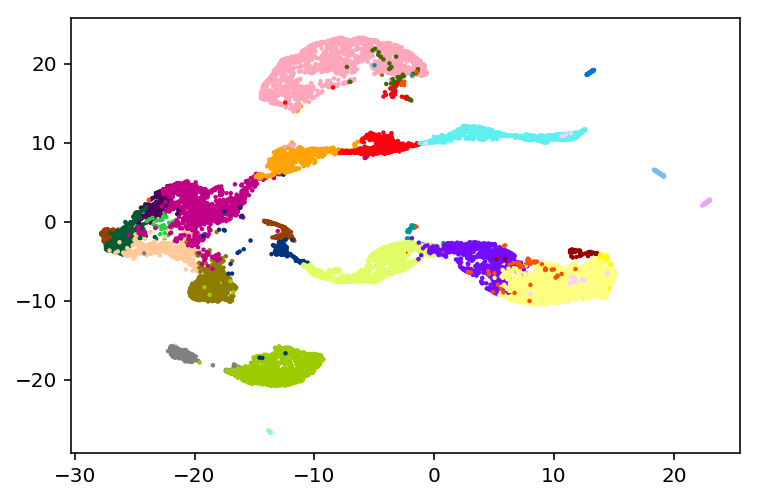

In [34]:
plt.scatter(xy[:,0], xy[:,1],c=cg.colorize(labels),marker='.',lw=0,s=20)

In [93]:
with loompy.connect("/Users/stelin/WholeTabula.loom") as ds:
    print(np.unique(ds.ca.tissue))

['Bladder' 'Heart_and_Aorta' 'Kidney' 'Limb_Muscle' 'Liver' 'Lung'
 'Mammary_Gland' 'Marrow' 'Spleen' 'Thymus' 'Tongue' 'Trachea']


In [41]:
import numpy as np
import torch
from torch.autograd import Variable
from sklearn.decomposition import PCA
import scipy.sparse as sparse
from tqdm import trange
from scipy.stats import linregress
from typing import *
from types import SimpleNamespace
import loompy


class VelocityInference:
    def __init__(self, n_components: int = 10, lr: float = 0.0001, n_epochs: int = 10) -> None:
        self.lr = lr
        self.n_components = n_components

        self.n_epochs = n_epochs
        self.loss: float = 0
        self.a: np.ndarray = None
        self.b: np.ndarray = None
        self.g: np.ndarray = None

    def fit(self, ds: loompy.LoomConnection, g_init: np.ndarray = None) -> Any:
        """
        Args:
            s      (n_genes, n_cells)
            u      (n_genes, n_cells)
        """
        n_cells = ds.shape[1]
        logging.info("Determining selected genes")
        selected = (ds.ra.Selected == 1)
        n_genes = selected.sum()
        n_components = ds.ca.HPF.shape[1]
        logging.info("Loading spliced")
        s_data = ds["spliced"][:,:][selected, :].astype("float")
        logging.info("Loading unspliced")
        u_data = ds["unspliced"][:,:][selected, :].astype("float")
        logging.info("Loading HPF")
        m_data = ds.ra.HPF[selected, :]
        
        # Set up the optimization problem
        logging.info("Setting up the optimization problem")
        dt = torch.float
        if g_init is not None:
            g = Variable(torch.tensor(g_init, dtype=dt), requires_grad=True)
        else:
            g = Variable(0.1 * torch.ones(n_genes, dtype=dt), requires_grad=True)
        self.model = SimpleNamespace(
            s=Variable(torch.tensor(s_data, dtype=dt)),
            u=Variable(torch.tensor(u_data, dtype=dt)),
            m=Variable(torch.tensor(m_data, dtype=dt)),
            v=Variable(torch.tensor(np.random.normal(0, 1, size=(n_components, n_cells)), dtype=dt), requires_grad=True),
            b=Variable(torch.ones(n_genes, dtype=dt), requires_grad=True),
            g=g
        )
        logging.info("Optimizing")
        self.epochs(self.n_epochs)
        return self

    def epochs(self, n_epochs: int) -> Any:
        m = self.model
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.SGD([m.v, m.b, m.g], lr=self.lr)

        for epoch in trange(n_epochs):
            optimizer.zero_grad()
            left = m.m @ m.v
            right = m.b.unsqueeze(1) * m.u - m.g.unsqueeze(1) * m.s - m.m @ m.v
            loss_out = loss_fn(left, right)
            loss_out.backward()
            optimizer.step()
            m.b.data.clamp_(min=0)
            m.g.data.clamp_(min=0)

        self.loss = float(loss_out)
        self.v = m.v.detach().numpy()
        self.b = m.b.detach().numpy()
        self.g = m.g.detach().numpy()
        return self


In [42]:
with loompy.connect("/Users/stelin/dh_20170213/L1_Subcortex.loom") as ds:
    vi = VelocityInference()
    vi.fit(ds)

2018-09-20 10:36:18,519 INFO: Determining selected genes
2018-09-20 10:36:18,524 INFO: Loading spliced
2018-09-20 10:36:25,335 INFO: Loading unspliced
2018-09-20 10:36:30,498 INFO: Loading HPF
2018-09-20 10:36:30,521 INFO: Setting up the optimization problem
2018-09-20 10:36:30,734 INFO: Optimizing
100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


In [44]:
vi.g

array([3.0400671e+22, 5.4426266e+21, 7.7372607e+21, ..., 0.0000000e+00,
       3.2705716e+17, 6.0784081e+17], dtype=float32)

In [8]:
with loompy.connect("/Users/stelin/dh_20170213/L1_Subcortex.loom") as ds:
    pl = cg.PolishedLouvain(outliers=False)
    labels = pl.fit_predict(ds, graph="KNN", embedding="HPF")
    ds.ca.Clusters = labels + min(labels)
    ds.ca.Outliers = (labels == -1).astype('int')
    logging.info(f"Found {labels.max() + 1} clusters")


2018-09-20 20:32:20,785 INFO: Louvain community detection
2018-09-20 20:33:35,853 INFO: Marking tiny clusters as outliers
2018-09-20 20:33:35,908 INFO: Using DBSCAN to mark outliers
2018-09-20 20:33:56,559 INFO: Using neighborhood to mark outliers
2018-09-20 20:34:01,760 INFO: Breaking clusters
2018-09-20 20:34:03,898 INFO: Smoothing cluster identity on the embedding
2018-09-20 20:34:10,548 INFO: Found 21 clusters


In [153]:
plt.cm.viridis([0,0.5,1])

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.127568, 0.566949, 0.550556, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ]])

2018-09-29 00:07:28,610 WARNING: ╭── 'get_edges' is deprecated. Use 'ds.row_graphs[name]' or 'ds.col_graphs[name]' instead
2018-09-29 00:07:28,611 WARNING: ╰──> at <ipython-input-28-163dbfc7f0ed>, line 7


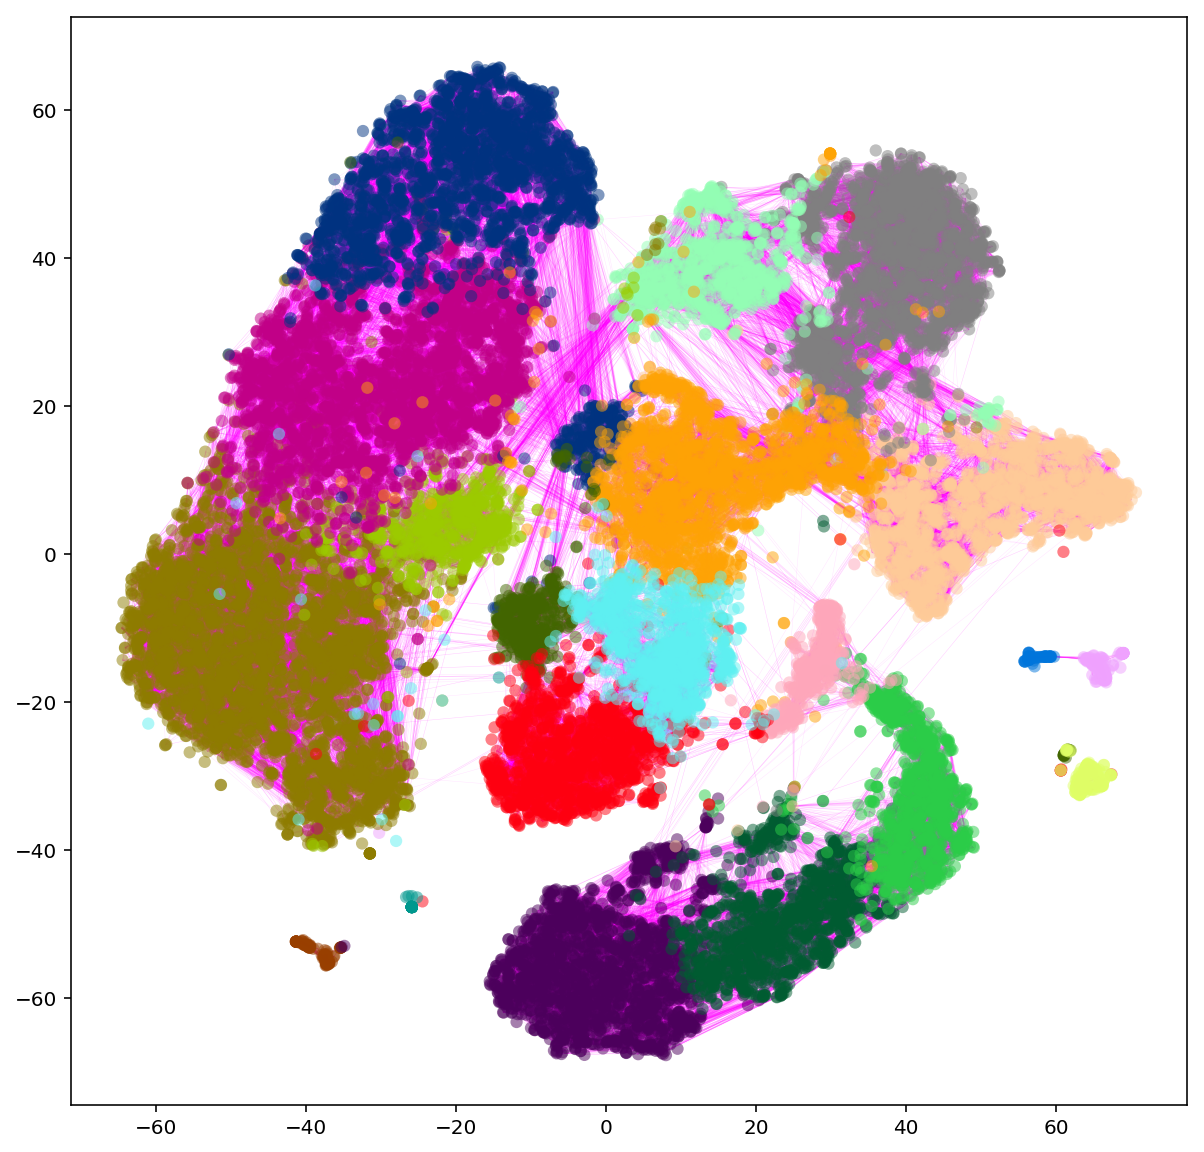

In [28]:
from matplotlib.collections import LineCollection
with loompy.connect("/Users/stelin/dh_20170213/L1_Subcortex.loom") as ds:
    xy = ds.ca.TSNE
    labels = ds.ca.Clusters
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    a, b, w = ds.get_edges("RNN", axis=1)
    lc = LineCollection(zip(xy[a], xy[b]), linewidths=0.25, zorder=0, color='magenta', alpha=0.1)
    ax.add_collection(lc)
    plt.scatter(xy[:,0], xy[:,1],c=cg.colorize(labels),marker='.',lw=0,s=150, alpha=0.5)
#    plt.xlim(-70,70)
#    plt.ylim(-70,70)

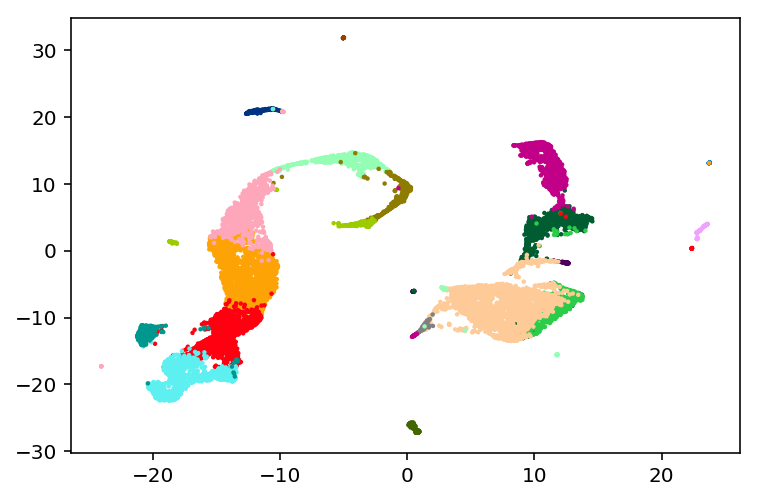

In [9]:
with loompy.connect("/Users/stelin/dh_20170213/L1_Cortex_w11.loom") as ds:
    xy = ds.ca.UMAP
    labels = ds.ca.Clusters
    plt.scatter(xy[:,0], xy[:,1],c=cg.colorize(labels),marker='.',lw=0,s=20)

In [24]:
import ipyvolume as ipv
import loompy
import cytograph as cg
from sklearn.manifold import TSNE
with loompy.connect("/Users/stelin/dh_20170213/L1_TabulaMuris.loom") as ds:
    #xyz = cg.tsne_js(ds.ca.HPF, n_components=3)
    xyz = ds.ca.TSNE3D
    labels = ds.ca.Clusters
    mknn = ds.col_graphs.MKNN.tocsr()
    x, y, z = xyz[:,0],xyz[:,1],xyz[:,2]
ipv.quickscatter(x, y, z, color=cg.colorize(labels), alpha=0.5,size=1.5, marker="sphere")

In [255]:
with loompy.connect("/Users/stelin/dh_20170213/L1_Subcortex.loom") as ds:
    knn = ds.col_graphs.KNN
    knn.setdiag(0)
    inside = knn.data > radius
    rnn = sparse.coo_matrix((knn.data[inside], (knn.row[inside], knn.col[inside])), shape=knn.shape)

In [131]:
with loompy.connect("/Users/stelin/dh_20170213/L1_MouseMidbrainE12E15.loom") as ds:
    knn = ds.col_graphs.KNN
    knn.setdiag(0)
    dmax=knn.max(axis=1).toarray()[:,0]
    xy = ds.ca.TSNE
radius = 0.8
cells = dmax > radius
n_cells_inside = cells.sum()
n_cells = dmax.shape[0]
cells_pct = int(100 - 100 * (n_cells_inside / n_cells))
n_edges_inside = (knn.data > radius).sum()
n_edges = (mknn.data > 0).sum()
edges_pct = int(100 * (n_edges_inside / n_edges))

plt.figure(figsize=(12,12))
plt.suptitle(f"Neighborhood characteristics (radius = {radius})\n{n_cells - n_cells_inside} of {n_cells} cells lack neighbors ({cells_pct}%)\n{n_edges_inside} of {n_edges} edges retained ({edges_pct}%)", fontsize=14)

ax=plt.subplot(221)
ax.scatter(xy[:,0], xy[:,1], c='lightgrey',s=1)
cax = ax.scatter(xy[:,0][cells], xy[:,1][cells], c=dmax[cells],vmin=radius,vmax=0.95,cmap="viridis",s=1)
plt.colorbar(cax)
plt.title("Farthest neighbor similarity")

ax=plt.subplot(222)
ax.scatter(xy[:,0], xy[:,1], c='lightgrey',s=1)
ax.scatter(xy[:,0][~cells], xy[:,1][~cells], c="red",s=1)
plt.title("Cells with no neighbors")

ax=plt.subplot(223)
ax.scatter(xy[:,0], xy[:,1], c='lightgrey',s=1)
subset = np.random.choice(np.sum(knn.data > radius), size=500)
lc = LineCollection(zip(xy[knn.row[knn.data > radius]][subset], xy[knn.col[knn.data > radius]][subset]), linewidths=0.5, color="red")
ax.add_collection(lc)
plt.title("Edges inside radius (500 samples)")

ax=plt.subplot(224)
ax.scatter(xy[:,0], xy[:,1], c='lightgrey',s=1)
subset = np.random.choice(np.sum(knn.data < radius), size=500)
lc = LineCollection(zip(xy[knn.row[knn.data < radius]][subset], xy[knn.col[knn.data < radius]][subset]), linewidths=0.5, color="red")
ax.add_collection(lc)
plt.title("Edges outside radius (500 samples)")

NameError: name 'mknn' is not defined

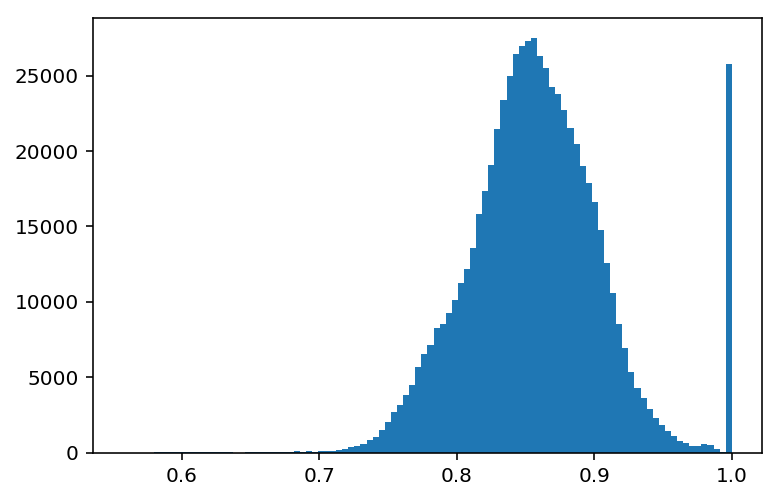

In [235]:
with loompy.connect("/Users/stelin/dh_20170213/L1_MouseMidbrainE12E15.loom") as ds:
    mknn = ds.col_graphs.KNN
_=plt.hist(mknn.data, bins=100)

In [260]:
import numpy as np
with loompy.connect("/Users/stelin/dh_20170213/L1_Subcortex.loom") as ds:
    #xyz = cg.tsne_js(ds.ca.HPF, n_components=3)
    mknn = ds.col_graphs.RNN.tocsr()
    labels = ds.ca.Clusters
    n_labels = labels.max() + 1
    w = np.zeros((n_labels,n_labels))
    n = np.zeros(n_labels)
    for i in range(n_labels):
        subgraph = mknn[labels == i, :]
        for j in range(n_labels):
            w[i,j] = subgraph[:, labels == j].sum()
        n[i] = subgraph.shape[0]

['Age', 'Cell_Conc', 'ChipID', 'Clusters', 'Comments', 'Date_Captured', 'DonorID', 'HPF', 'Label', 'NGI_PlateWell', 'NGenes', 'Num_Pooled_Animals', 'Outliers', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'TSNE', 'TSNE3D', 'Target_Num_Cells', 'Tissue', 'TotalRNA', 'Transcriptome', 'UMAP', 'UMAP3D', 'Valid', 'cDNA_Lib_Ok', 'ngperul_cDNA']


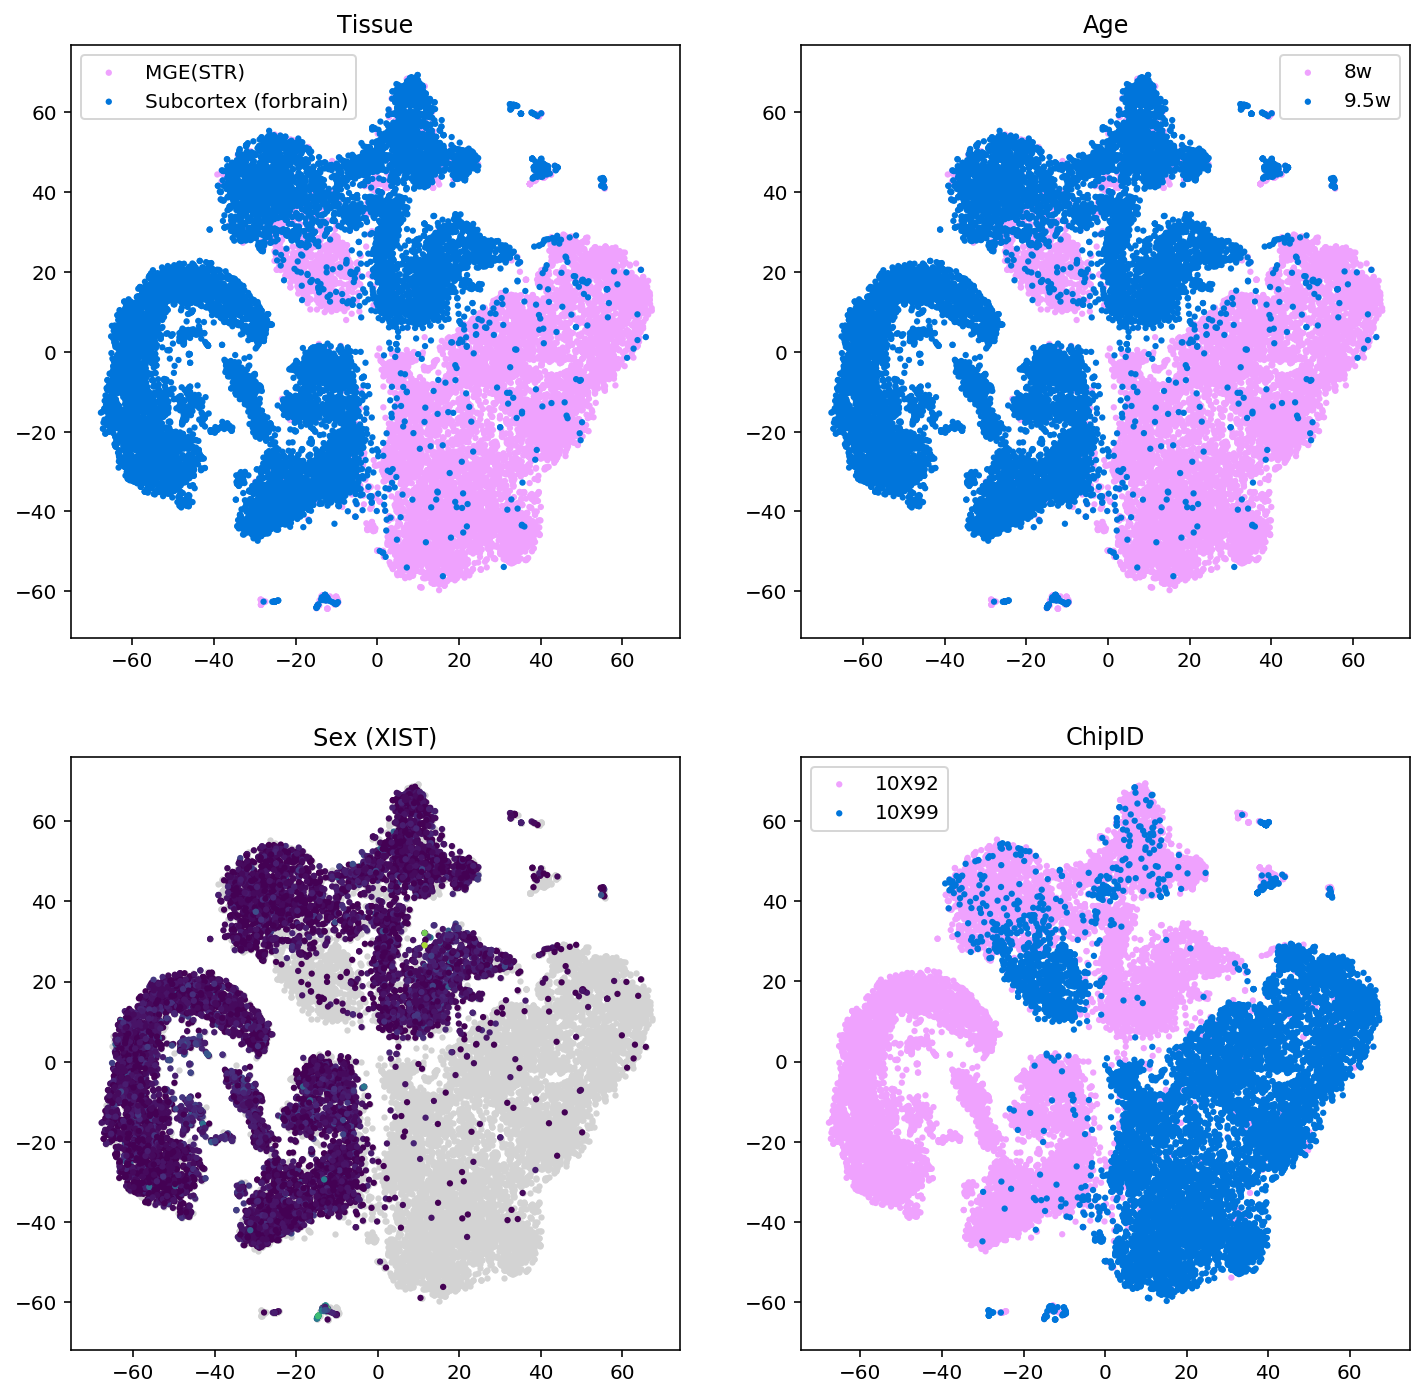

In [129]:
with loompy.connect("/Users/stelin/dh_20170213/L1_Subcortex.loom") as ds:
    xy = ds.ca.TSNE
    plt.figure(figsize=(12,12))
    labels = ds.ca.Tissue
    ax = plt.subplot(221)
    for lbl in np.unique(labels):
        cells = labels == lbl
        ax.scatter(xy[:,0][cells], xy[:,1][cells],c=cg.colorize(labels)[cells], label=lbl,lw=0,s=10)
    ax.legend()
    plt.title("Tissue")

    labels = ds.ca.Age
    ax = plt.subplot(222)
    for lbl in np.unique(labels):
        cells = labels == lbl
        ax.scatter(xy[:,0][cells], xy[:,1][cells],c=cg.colorize(labels)[cells], label=lbl,lw=0,s=10)
    ax.legend()
    plt.title("Age")
    
    ax = plt.subplot(223)
    xist = ds[ds.ra.Gene == "XIST", :][0]
    cells = xist > 0
    ax.scatter(xy[:,0], xy[:,1],c='lightgrey',lw=0,s=10)
    ax.scatter(xy[:,0][cells], xy[:,1][cells],c=xist[cells],lw=0,s=10)
    plt.title("Sex (XIST)")

    labels = ds.ca.ChipID
    ax = plt.subplot(224)
    for lbl in np.unique(labels):
        cells = labels == lbl
        ax.scatter(xy[:,0][cells], xy[:,1][cells],c=cg.colorize(labels)[cells], label=lbl,lw=0,s=10)
    ax.legend()
    plt.title("ChipID")
    

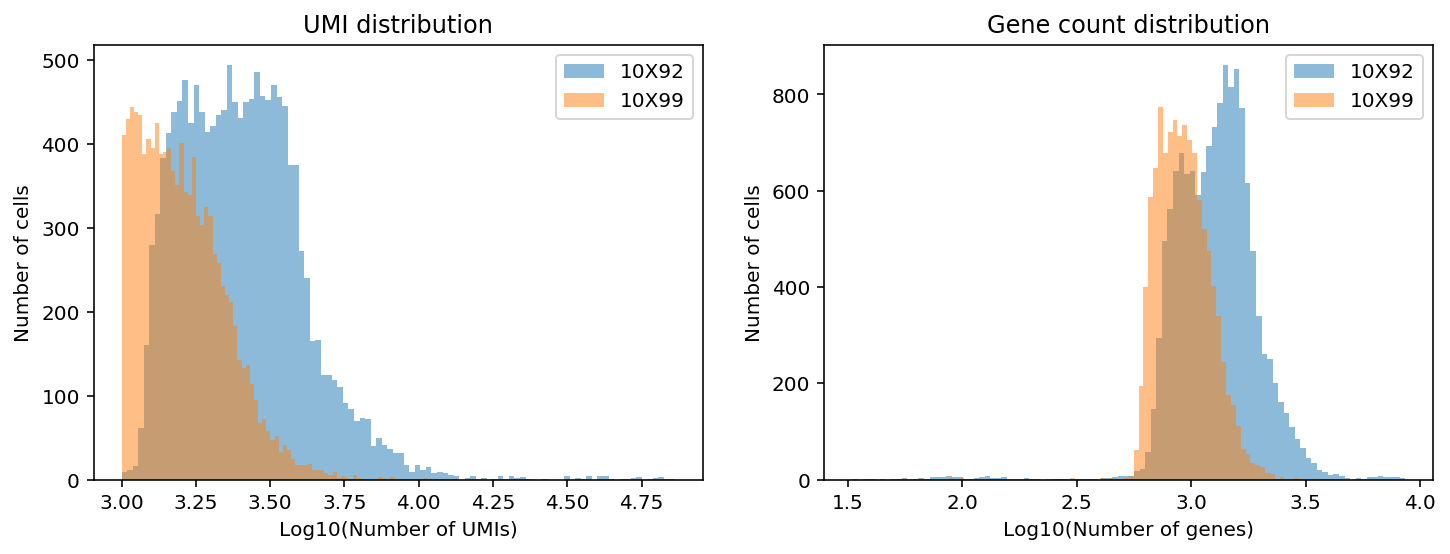

In [156]:
with loompy.connect("/Users/stelin/dh_20170213/L1_Subcortex.loom") as ds:
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    for chip in np.unique(ds.ca.ChipID):
        cells = ds.ca.ChipID == chip
        plt.hist(np.log10(ds.ca.TotalRNA[cells]), bins=100, label=chip, alpha=0.5)
        plt.title("UMI distribution")
        plt.ylabel("Number of cells")
        plt.xlabel("Log10(Number of UMIs)")
    plt.legend()
    plt.subplot(122)
    for chip in np.unique(ds.ca.ChipID):
        cells = ds.ca.ChipID == chip
        plt.hist(np.log10(ds.ca.NGenes[cells]), bins=100, label=chip, alpha=0.5)
        plt.title("Gene count distribution")
        plt.ylabel("Number of cells")
        plt.xlabel("Log10(Number of genes)")
    plt.legend()

    

In [157]:
with loompy.connect("/Users/stelin/dh_20170213/L1_Subcortex.loom") as ds:
    genes = np.arange(50)
    loompy.create("test.loom", ds[genes, :], col_attrs=ds.ca, row_attrs=ds.ra[genes])

In [389]:
x = np.arange(10)
x.ndim

1

In [78]:
from typing import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

class Plot:
    def __init__(self, ds, size: Tuple[float, float] = None, shape: Tuple[int, int] = (1,1)) -> None:
        self.ds = ds
        if size is None:
            self.w = shape[1] * 6
            self.h = shape[0] * 6
        else:
            self.w = size[0]
            self.h = size[1]
        self.n_rows = shape[0]
        self.n_cols = shape[1]
        
        self.loc = (0, 0)
        plt.figure(figsize=(self.w, self.h))
        plt.subplots_adjust(hspace=0.1, wspace=0.1)

    def _data_for(self, name, *, dims: int = 1, layer: str = "", transposed: bool = False):
        ds = self.ds
        if transposed:
            if type(name) is np.ndarray:
                if name.shape[0] != ds.shape[0]:
                    raise ValueError("Array length must match number of rows in file")
                if name.ndim != dims:
                    raise ValueError(f"Array must have {dims} dimensions, but has {name.ndim} dimensions")                    
                return name
            if name in ds.ra:
                return ds.ra[name]
            for attr in ds.ca.keys():
                if name in ds.ca[attr]:
                    return ds[layer][:, ds.ca[attrs] == name][0]
        else:
            if type(name) is np.ndarray:
                if name.shape[0] != ds.shape[1]:
                    raise ValueError("Array length must match number of rows in file")
                if name.ndim != dims:
                    raise ValueError(f"Array must have {dims} dimensions, but has {name.ndim} dimensions")                    
                return name
            if name in ds.ca:
                return ds.ca[name]
            if "Gene" in ds.ra and name in ds.ra.Gene:
                return ds[layer][ds.ra.Gene == name, :][0]
            for attr in ds.ra.keys():
                if name in ds.ra[attr]:
                    return ds[layer][ds.ra[attrs] == name, :][0]
            raise ValueError(f"'{name}' not found in file")


    def scatter(self, xy: str = "TSNE", color_by:str = None, split_by: str = None, size_by: str = None, zi: bool = True, size: float = 10, cmap="viridis", show_axes: bool = False, show_legend: bool = True, span: int = 1, axis_labels: Union[Tuple, str] = "auto", layer: str = "", transposed: bool = False) -> None:
        if type(xy) is tuple:
            x = self._data_for(xy[0], layer=layer, transposed=transposed)
            y = self._data_for(xy[1], layer=layer, transposed=transposed)
            if axis_labels == "auto":
                axis_labels = (xy[0], xy[1])
        else:
            temp = self._data_for(xy, dims=2, layer=layer, transposed=transposed)
            x = temp[:, 0]
            y = temp[:, 1]
            if axis_labels == "auto":
                axis_labels = False

        if self.loc[0] >= self.n_rows:
            raise ValueError(f"Too many panels for layout of {self.n_rows} rows and {self.n_cols} columns.")
        ax = plt.subplot2grid((self.n_rows, self.n_cols), self.loc, rowspan=span)
        col = self.loc[1] + span
        row = self.loc[0]
        if col >= self.n_cols:
            col = 0
            row = row + 1
        self.loc = (row, col)

        if size_by is not None:
            size = size * self._data_for(size_by, layer=layer, transposed=transposed)
        if not show_axes:
            plt.axis("off")
        if zi:
            plt.scatter(x, y, s=size, c='lightgrey', lw=0)
        if axis_labels:
            plt.xlabel(axis_labels[0])
            plt.ylabel(axis_labels[1])
        if color_by is not None:
            if color_by.endswith(":C"):
                c = np.array([str(x) for x in self._data_for(color_by[:-2], layer=layer, transposed=transposed)], dtype=object)
            else:
                c = self._data_for(color_by, layer=layer, transposed=transposed)
            if np.issubdtype(c.dtype, np.object_):
                for ix, lbl in enumerate(np.unique(c)):
                    cols = (c == lbl)
                    plt.scatter(x[cols], y[cols], s=size, c=cg.colors75[ix], lw=0, label=lbl)
                if show_legend:
                    plt.legend()
            else:
                if zi:
                    cols = (c > 0)
                    plt.scatter(x[cols], y[cols], s=size, c=c[cols], cmap=cmap, lw=0)
                else:
                    plt.scatter(x, y, s=size, c=c, cmap=cmap, lw=0)
                if show_legend:
                    cbaxes = inset_axes(ax, width="30%", height="5%", loc=2)
                    cbar = plt.colorbar(cax=cbaxes, orientation='horizontal')
                    cbar.set_label(color_by)


In [53]:
f = "/Users/stelin/dh_20170213/L1_Cortex_CRL44.loom"
with loompy.connect(f) as ds:
    s = ds["spliced_exp"][ds.ra.Selected == 1, :]
    u = ds["unspliced_exp"][ds.ra.Selected == 1, :]

In [ ]:
vi = cg.VelocityInference()
vi.fit()

In [59]:
np.issubdtype(np.arange(10).dtype, np.bool_)

False

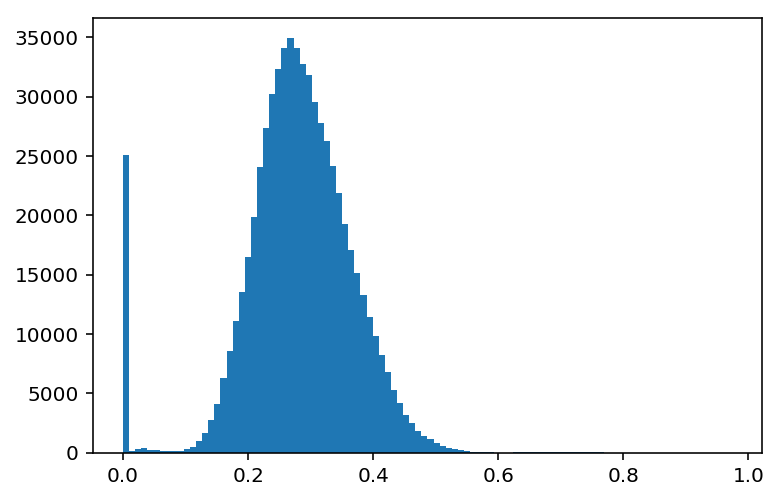

In [60]:
with loompy.connect("/Users/stelin/dh_20170213/L1_Subcortex.loom") as ds:
#    plt.scatter(ds.ca.TSNE[:,0],ds.ca.TSNE[:,1], c=cg.colorize(ds.ca.Clusters),marker='.')
    plt.hist(1-ds.col_graphs.KNN.data, bins=100)

In [2]:
with loompy.connect("/Users/stelin/dh_20170213/L1_TabulaMuris.loom") as ds:
    knn = ds.col_graphs.KNN
    theta = ds.ca.HPF
    jsd_correct = []
    jsd_wrong = []
    i = 0
    for j in range(10000):
        jsd_correct.append(np.sqrt(cg.jensen_shannon_divergence(theta[i, :], theta[j, :])))
        jsd_wrong.append(cg.jensen_shannon_distance(theta[i, :], theta[j, :]))